<p style="line-height:2">
Notebook obtained from Rober Moller's Kaggle post. <br>
Link : <a link="https://www.kaggle.com/code/robertmoller/notebook7fc8dabee6" targe="_blank">https://www.kaggle.com/code/robertmoller/notebook7fc8dabee6</a>
</p>

In [1]:
# Import inbuilt libraries
import os, pathlib, shutil
from math import sqrt, ceil, floor

# Import necessary libraries for data processing
import numpy as np
import pandas as pd
import seaborn as sns  
import matplotlib.pyplot as plt

# Import necessary libraries for image processing
from PIL import Image

# Import necessary libraries for tensorflow model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Constants

In [2]:
batch_size = 32

# image dimensions
img_width = 1536
img_height = 662

# number of epochs itenrations to train the model
epochs = 10

# Scale the image to a smaller size for faster processing
img_target_scale = .1
img_target_width = int(floor(img_width * img_target_scale))
img_target_height= int(floor(img_height * img_target_scale))

INTERPOLATION = "bilinear"
AUTOTUNE = tf.data.AUTOTUNE

In [3]:
def count_samples(path):
    return path.name, len(list(path.glob('*')))

# path for the dataset folder
working_dir = pathlib.Path().absolute()
data_dir = pathlib.Path(os.path.join(working_dir, 'compressed_dataset'))

# Create a list of all the labels and the number of samples in each label
zipped_data_distribution = list(map(count_samples ,data_dir.glob('*/')))
country_image_count = {x : y for x, y in zipped_data_distribution}

## Exploratory Data Analysis

### Pictures per Country (original dataset)

Creates a heatmap to visualize the number of images available in the dataset. The color of the country is determined by the number of images available. <br>
On the color specturm, the dark blue represents the countries with the least number of images, while the dark red represents the countries with the most number of images.

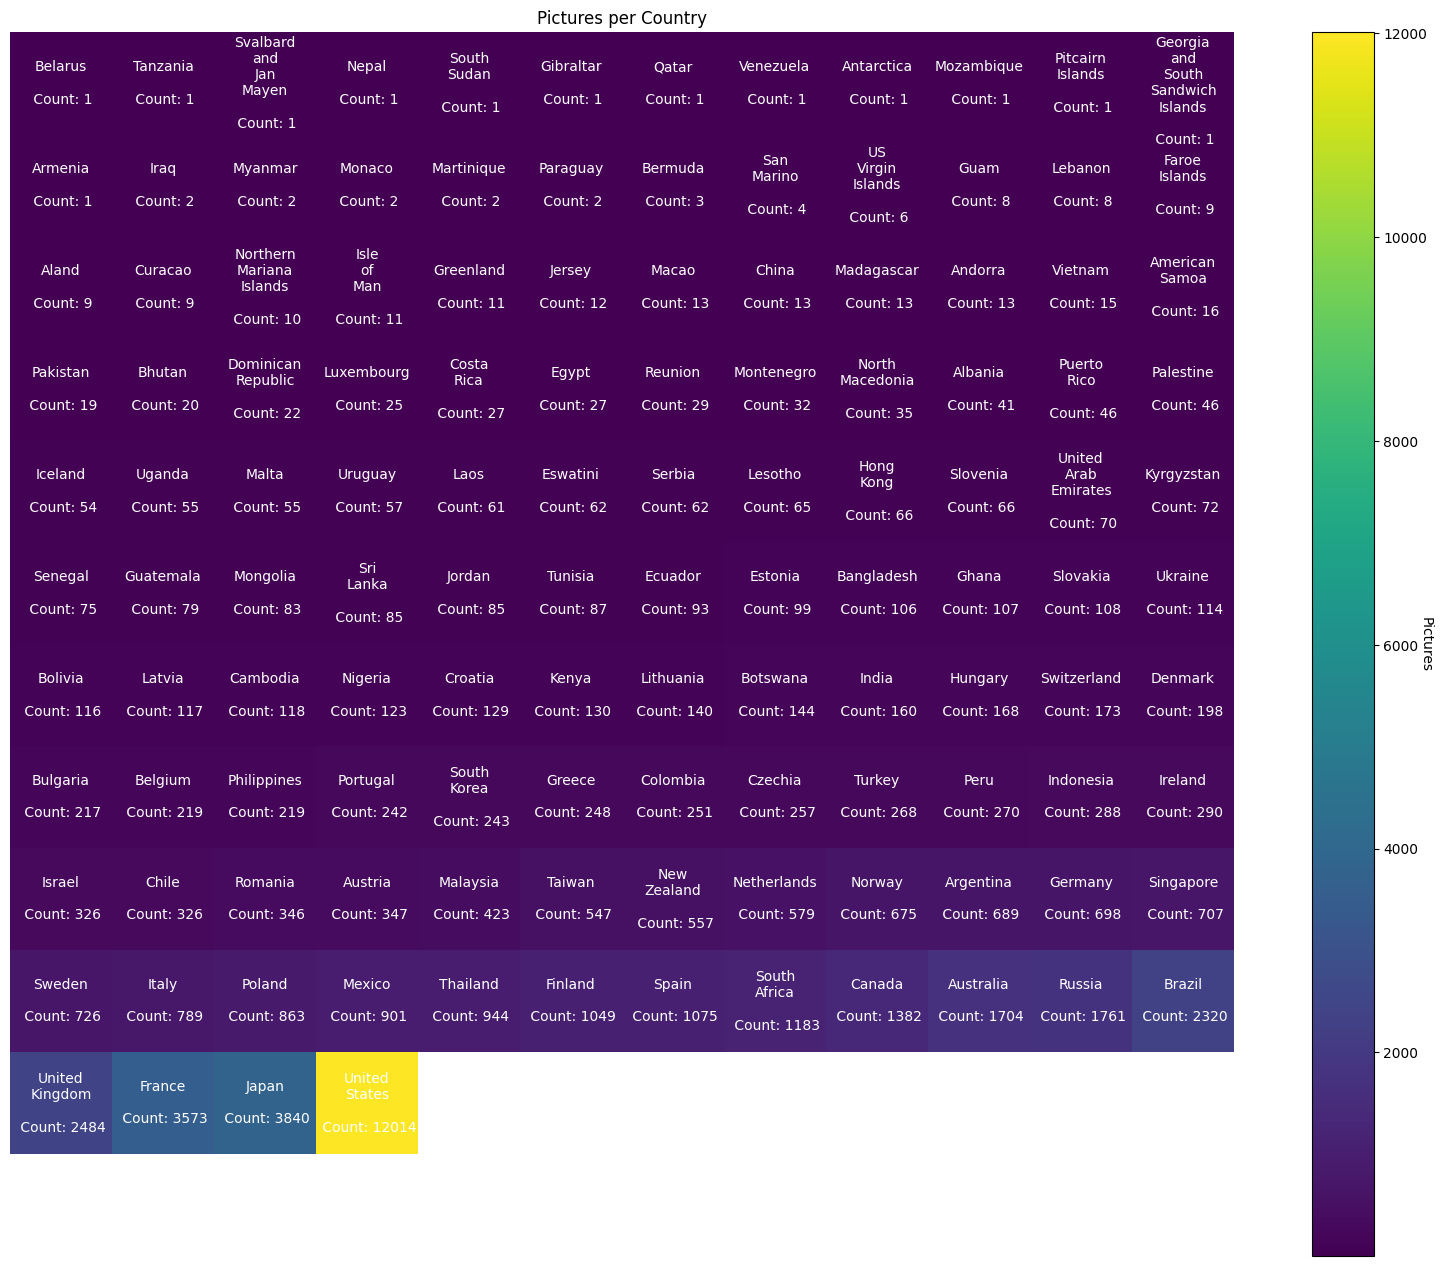

In [4]:
# Unzipping the data
data_distribution = list(zip(*sorted(zipped_data_distribution, key=lambda x: x[1])))


def createHeatmap(dataset, title, spectrum):
    labels, samples = dataset
    
    # Shaping Data to fit graph by finding the max size of the grid to fit all the images
    grid_size = ceil(sqrt(len(samples)))**2

    pad = '-'
    n_labels = list(labels) + ([pad] * (grid_size - len(labels)))
    n_samples = list(samples) + ([np.nan] * (grid_size - len(samples)))

    samples = np.split(np.array(n_samples), sqrt(grid_size))

    # Heatmap
    fig, ax = plt.subplots()
    im = ax.imshow(samples)
    
    ax.set_title(title)
    
    fig.set_size_inches(16, 13, forward=True)
    fig.tight_layout()

    # Color bar
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel('Pictures', rotation=-90)

    # Annotations
    ax.tick_params(left=False, bottom=False)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    for i in range(len(samples)):
        for j in range(len(samples[i])):
            label_index = i * len(samples) + j
            label =  "{}\n\n Count: {}".format(n_labels[label_index].replace(' ', '\n'), n_samples[label_index])
            value = samples[i][j]
            text = ax.text(j, i,label, ha="center", va="center", color="w")
    
    # Styling
    ax.spines[:].set_visible(False)
    cmap = plt.get_cmap(spectrum)
    plt.set_cmap(cmap)

    plt.show()
    
createHeatmap(data_distribution, "Pictures per Country", 'turbo')

### Statistics

To get a better understanding of the dataset, we calculate some basic statistics such as the mean, median, standard deviation, and the range of the latitude and longitude values.

In [5]:
df = pd.DataFrame(zipped_data_distribution, columns=['label', 'count'])

df.describe()

,count
count,124.000000
mean,403.201613
std,1220.045061
min,1.000000
25%,13.000000
50%,81.000000
75%,268.500000
max,12014.000000


### Pictures per Country (filtered)
We filter out to only keep the countries with `100 >= pictures <= 10000` because we want to have a good amount of pictures per country to train our model on.<br/>
And having 100 as the mimimum amount as the 50% of the countries have 81 pictures or less.

In [6]:
filtered_zipped_data_distribution = [ (country, pictures) for country, pictures in zipped_data_distribution if 100 <= pictures and pictures <= 10000 ]

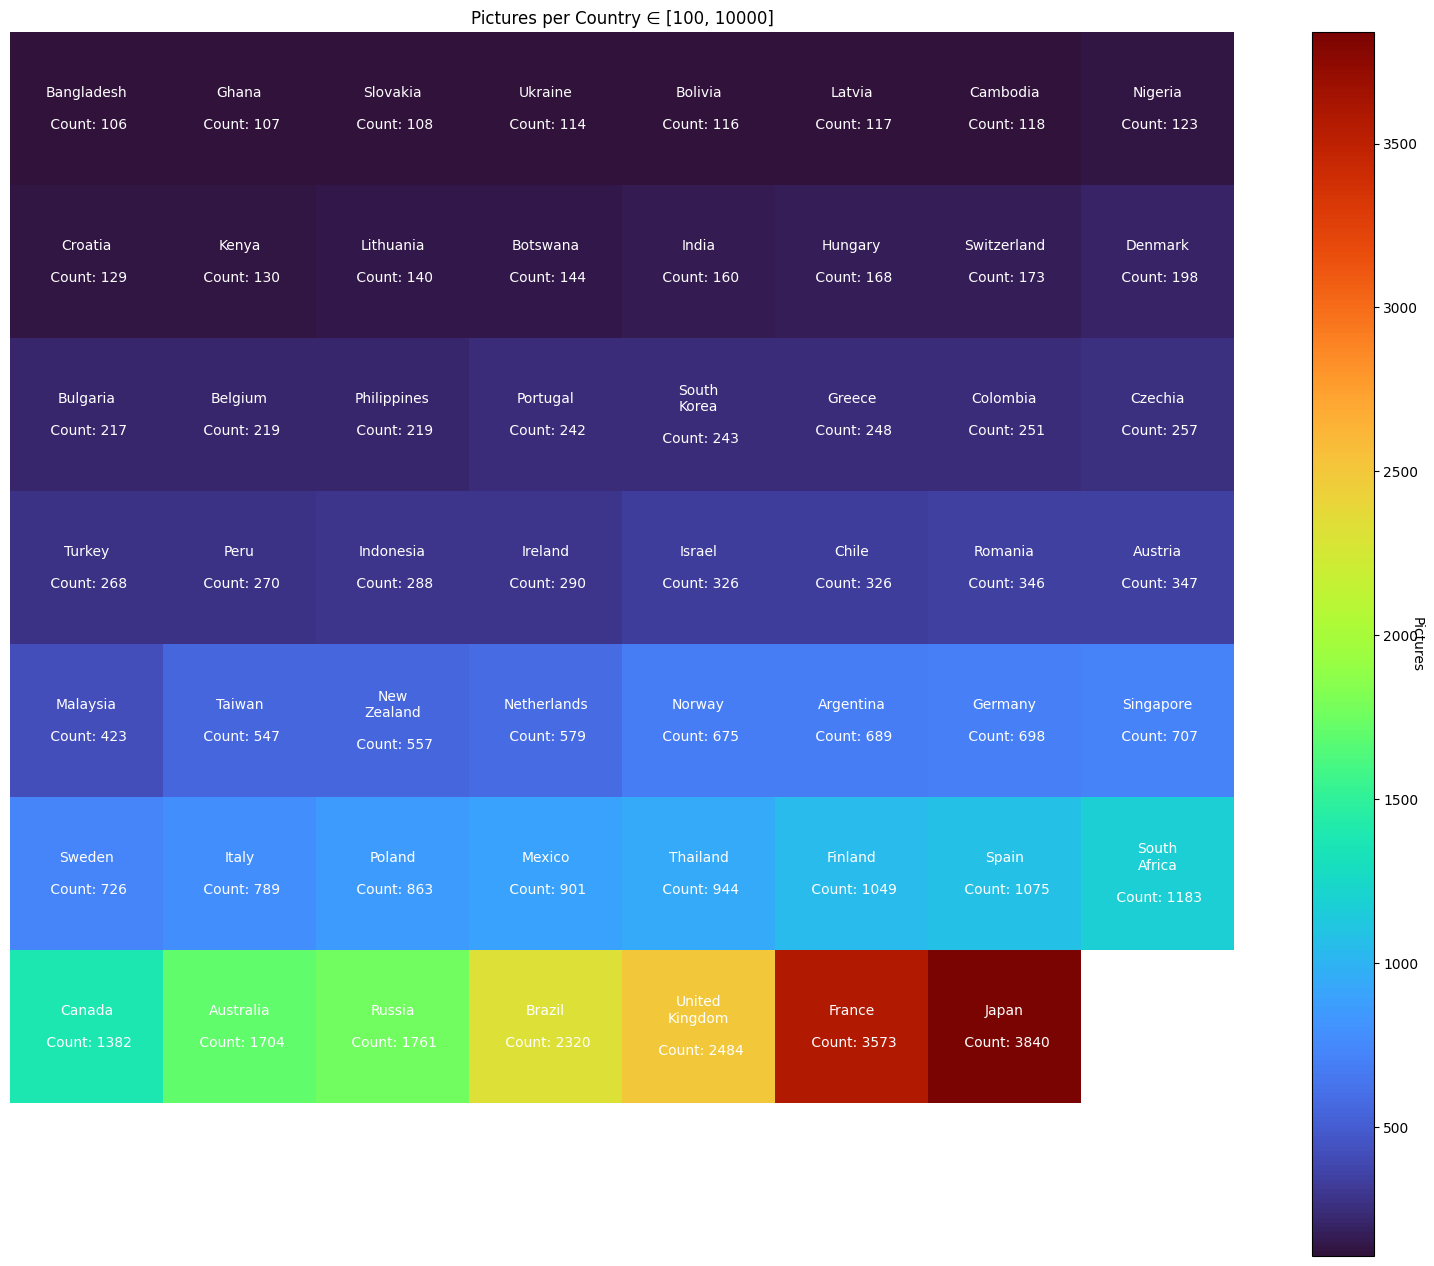

In [7]:
filtered_data = list(zip(*sorted(filtered_zipped_data_distribution, key=lambda x: x[1])))

createHeatmap(filtered_data, "Pictures per Country ∈ [100, 10000]", 'turbo')

## Filter Dataset

Create a new dataset with only the countries that have `100 <= pictures <= 10000` pictures.

In [8]:
filtered_dataset_dir = pathlib.Path(os.path.join(working_dir,  'filtered_dataset'))

# Create a new directory for the filtered dataset
filtered_dataset_dir.mkdir(exist_ok=True)

# Copy the filtered dataset to the new directory
for country, picture_count in filtered_zipped_data_distribution:
    for picture_path in data_dir.glob(f'{country}/*'):
        target_picture_path = filtered_dataset_dir / picture_path.name
        shutil.copy(picture_path, target_picture_path)

## Load Filtered Dataset

Create a train and validation dataset from the filtered dataset with a 80/20 split. <br/>
The train dataset will be used to train the model, while the validation dataset will be used to evaluate the model.

In [9]:
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="both",
  seed=123,
  image_size=(img_target_height, img_target_width),
  batch_size=batch_size)

Found 49997 files belonging to 124 classes.
Using 39998 files for training.
Using 9999 files for validation.


In [10]:
print("Number of Countries in Train dataset: ", len(train_ds.class_names))
print("Number of Countries in Validation dataset: ", len(val_ds.class_names))
print("Number of Countries in both datasets: ", len(set(train_ds.class_names).intersection(set(val_ds.class_names))))

Number of Countries in Train dataset:  124
Number of Countries in Validation dataset:  124
Number of Countries in both datasets:  124


## Pre-processing
1. downscale image to 50% of original size
2. filter out countries with less than 100 samples
3. filter out countries with more than 10000 samples

In [11]:
def downscale_image(image, label):
    # Function to downscale the image to a smaller size for faster processing
    image = tf.image.resize(image, [img_target_width, img_target_height], antialias=True,)
    return image, label

In [12]:
# Preporcess a validation dataset by caching it, applying a downscaling function to each element in parallel, and
# prefetching the preprocessed data for better performance during model training or evaluation

reprocessed_val_ds = val_ds.cache() \
    .map(downscale_image, num_parallel_calls=AUTOTUNE) \
    .prefetch(buffer_size=AUTOTUNE)

In [13]:
# Create a Rescaling layer to normalize pixel values from [0, 255] to [0, 1].
normalization_layer = layers.Rescaling(1./255)

# Apply the normalization layer to the training dataset using the map function.
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

# Retrieve a batch of normalized images and labels from the dataset.
image_batch, labels_batch = next(iter(normalized_ds))

# Extract the first image from the batch for demonstration.
first_image = image_batch[0]

# Print the minimum and maximum pixel values of the first normalized image.
# This is to verify that the pixel values are now in the [0, 1] range.
print(np.min(first_image), np.max(first_image)) 

0.0 1.0


## Model Definition

Creates a Sequential model with multiple convolutional layers, max-pooling layers, and dense layers.

In [14]:
# Create a Sequential model.
model = Sequential([
  # Rescale input pixel values from [0, 255] to [0, 1] and specify the input shape.
  layers.Rescaling(1./255, input_shape=(img_target_height, img_target_width, 3)),
  
  # Convolutional layer with 16 filters, a 3x3 kernel, 'same' padding, and ReLU activation.
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  
   # Max pooling layer to downsample the spatial dimensions.
  layers.MaxPooling2D(),
  
   # Convolutional layer with 32 filters, a 3x3 kernel, 'same' padding, and ReLU activation.
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  
  # Max pooling layer to downsample the spatial dimensions.
  layers.MaxPooling2D(),
  
  # Convolutional layer with 64 filters, a 3x3 kernel, 'same' padding, and ReLU activation.
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  
  # Max pooling layer to downsample the spatial dimensions.
  layers.MaxPooling2D(),
  
  # Flatten layer to convert the 3D output to 1D for the dense layers.
  layers.Flatten(),
  
  # Dense layer with 128 units and ReLU activation.
  layers.Dense(128, activation='relu'),
  
  # Output layer with units equal to the number of classes and no activation function specified.
  layers.Dense(len(train_ds.class_names))
])

## Model Compilation
Compiles the model using the Adam optimizer, Sparse Categorical Crossentropy loss, and monitoring accuracy as a metric.

In [15]:
# Compile the model with the specified configuration.
model.compile(
    # Use the Adam optimizer for model training.
    optimizer='adam',
    
        # Specify Sparse Categorical Crossentropy as the loss function to produce logits as output.
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    
    # Monitor training accuracy as a metric.
    metrics=['accuracy']
)

In [16]:
# Print the defined model architecture.
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 66, 153, 3)        0         
                                                                 
 conv2d (Conv2D)             (None, 66, 153, 16)       448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 33, 76, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 33, 76, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 38, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 38, 64)        1

## Training the Model

Trains the model using the training dataset and validates it using the validation dataset.

In [17]:
# Train the model
history = model.fit(
  train_ds,
  
  # Validation dataset for monitoring performance during training.
  validation_data=val_ds,
  
  # Number of epochs, representing the number of times the model will iterate over the entire training dataset.
  epochs=epochs
)

Epoch 1/10
1250/1250 [==============================] - 109s 87ms/step - loss: 3.2364 - accuracy: 0.2511 - val_loss: 3.0531 - val_accuracy: 0.2633
Epoch 2/10
1250/1250 [==============================] - 112s 89ms/step - loss: 2.8858 - accuracy: 0.3012 - val_loss: 2.7853 - val_accuracy: 0.3187
Epoch 3/10
1250/1250 [==============================] - 111s 88ms/step - loss: 2.6502 - accuracy: 0.3412 - val_loss: 2.6691 - val_accuracy: 0.3373
Epoch 4/10
1250/1250 [==============================] - 112s 90ms/step - loss: 2.4486 - accuracy: 0.3776 - val_loss: 2.6590 - val_accuracy: 0.3510
Epoch 5/10
1250/1250 [==============================] - 110s 88ms/step - loss: 2.2706 - accuracy: 0.4127 - val_loss: 2.7018 - val_accuracy: 0.3454
Epoch 6/10
1250/1250 [==============================] - 113s 90ms/step - loss: 2.0819 - accuracy: 0.4481 - val_loss: 2.7617 - val_accuracy: 0.3503
Epoch 7/10
1250/1250 [==============================] - 112s 89ms/step - loss: 1.9027 - accuracy: 0.4860 - val_loss: 2

## Plotting Training History

Plots the training and validation accuracy and loss over epochs.

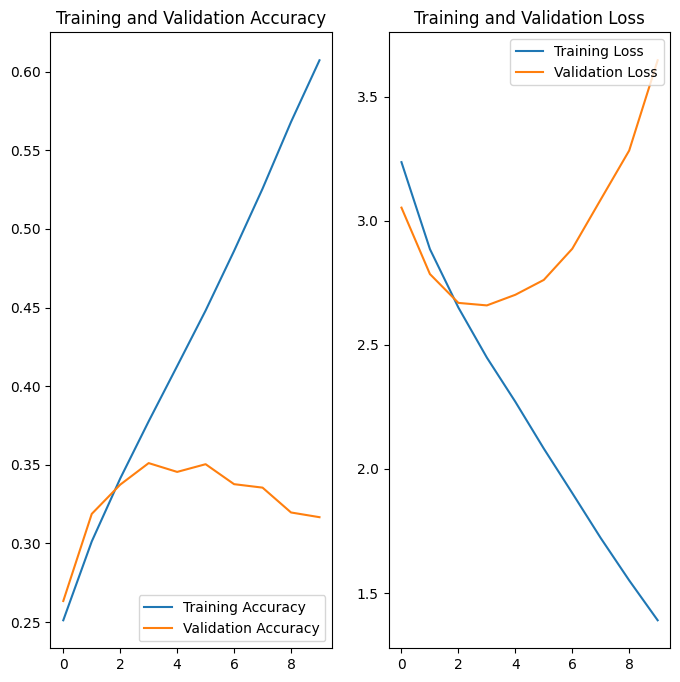

In [18]:
acc, val_acc  = history.history['accuracy'], history.history['val_accuracy']
loss, val_loss = history.history['loss'], history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()